In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

In [77]:
df = pd.read_csv('../data/processed/pulsar_processed.csv')

In [78]:
X = df.drop('target_class', axis=1)
y = df['target_class']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

As the dataset is imbalanced, we will use class_weight='balanced' in our Logistic Regression model.

In [80]:
log_reg = LogisticRegression(max_iter=1000,
                             class_weight='balanced',
                             solver='liblinear',
                             random_state=42)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [81]:
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

In [82]:
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy:', acc)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('ROC AUC:', roc_auc)

Accuracy: 0.9670391061452513
Precision: 0.774869109947644
Recall: 0.9024390243902439
F1 Score: 0.8338028169014085
ROC AUC: 0.9651809018090182


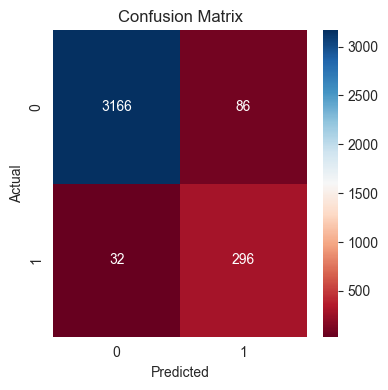

In [83]:
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdBu', xticklabels=[0,1], yticklabels=[0,1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

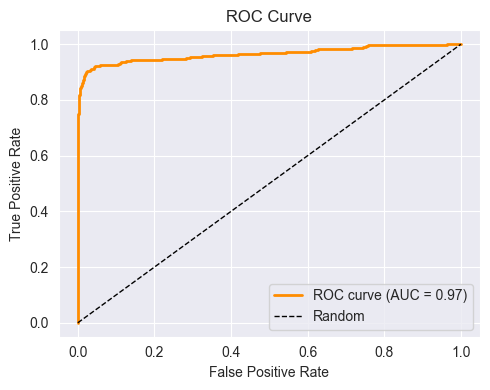

In [84]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--', lw=1, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()